# Time Series Analysis

In [1]:
# import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# load data and check header
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url)
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [3]:
# check info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


## Lesson 2: Wrangling Time Series Data

In [4]:
#convert column to datetime
df["Month"] = pd.to_datetime(df["Month"])
df.dtypes

Month         datetime64[ns]
Passengers             int64
dtype: object

In [5]:
# set month column as index
df.set_index("Month", inplace=True)
df.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


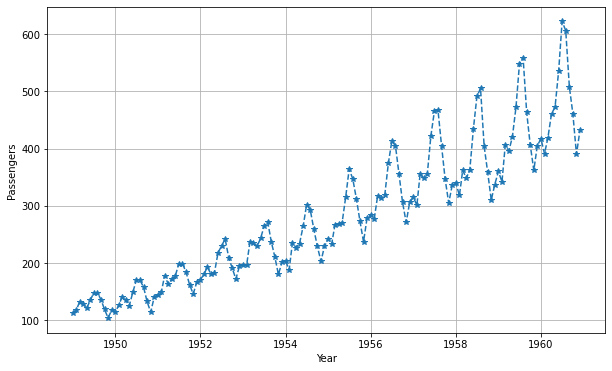

In [7]:
# visualize relationship
plt.figure(figsize=(10,6))
plt.plot(df.index, df.Passengers, '--', marker='*')
plt.grid()
plt.xlabel('Year')
plt.ylabel('Passengers');

In [8]:
#check for missing values
df.isnull().values.any()

False

> There are no missing values in our dataset however, in bid to explain how we handle missing values, we will make a copy of our dataset and delete some values at random.

In [9]:
df_copy = df.copy()
rows = df_copy.sample(frac=0.1, random_state=0)
rows['Passengers'] = np.nan
df_copy.loc[rows.index, 'Passengers'] = rows['Passengers']
df_copy.isnull().sum()

Passengers    14
dtype: int64

> There are now 14 missing values in the dataset

In [10]:
# Filling missing data by imputation - Forward fill
df_copy_ffill = df_copy.fillna(method='ffill')
df_copy_ffill.isnull().sum()

Passengers    0
dtype: int64

In [11]:
# Filling missing data by imputation - Backward fill
df_copy_bfill = df_copy.fillna(method='bfill')
df_copy_bfill.isnull().sum()

Passengers    0
dtype: int64

In [12]:
# Filling missing data by interpolation
df_copy_LIF = df_copy.interpolate(method='linear', limit_direction='forward')
df_copy_LIF.isnull().sum()

Passengers    0
dtype: int64

In [13]:
df_copy_LIB = df_copy.interpolate(method='linear', limit_direction='backward')
df_copy_LIB.isnull().sum()

Passengers    0
dtype: int64

## Downsampling and Upsampling

In [14]:
#Downsample to quarterly data points
df_quarterly = df.resample('3M').mean()

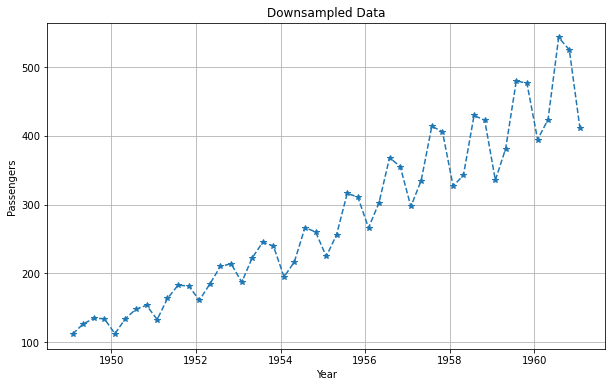

In [15]:
# visualize relationship
plt.figure(figsize=(10,6))
plt.plot(df_quarterly.index, df_quarterly.Passengers, '--', marker='*')
plt.grid()
plt.xlabel('Year')
plt.ylabel('Passengers')
plt.title("Downsampled Data");

In [16]:
#Upsample to daily data points
df_daily = df.resample('D').mean()

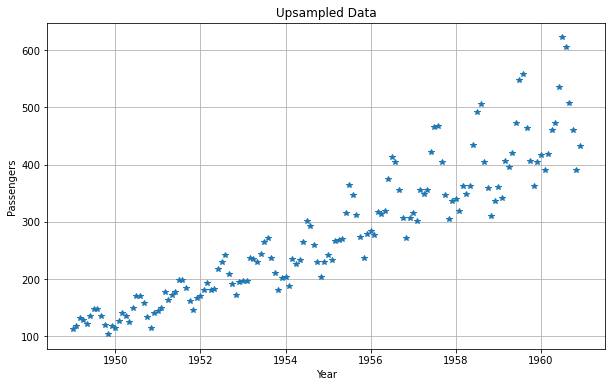

In [17]:
# visualize relationship
plt.figure(figsize=(10,6))
plt.plot(df_daily.index, df_daily.Passengers, '--', marker='*')
plt.grid()
plt.xlabel('Year')
plt.ylabel('Passengers')
plt.title("Upsampled Data");

In [18]:
# moving average
df_MA = df.copy()
MA = df_MA['Passengers'].rolling(12).mean()

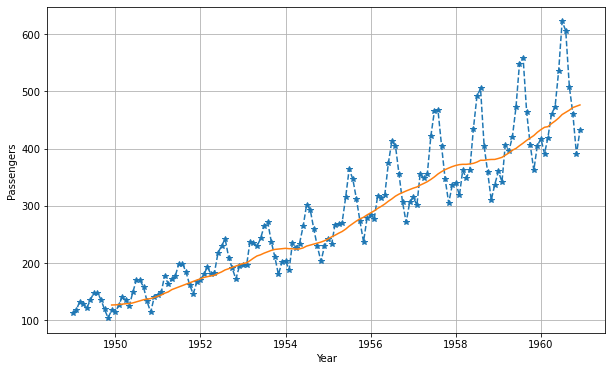

In [19]:
# visualize relationship
plt.figure(figsize=(10,6))
plt.plot(df.index, df.Passengers, '--', marker='*')
plt.plot(df_MA.index, MA)
plt.grid()
plt.xlabel('Year')
plt.ylabel('Passengers');

## Time Series Specific Exploratory Methods

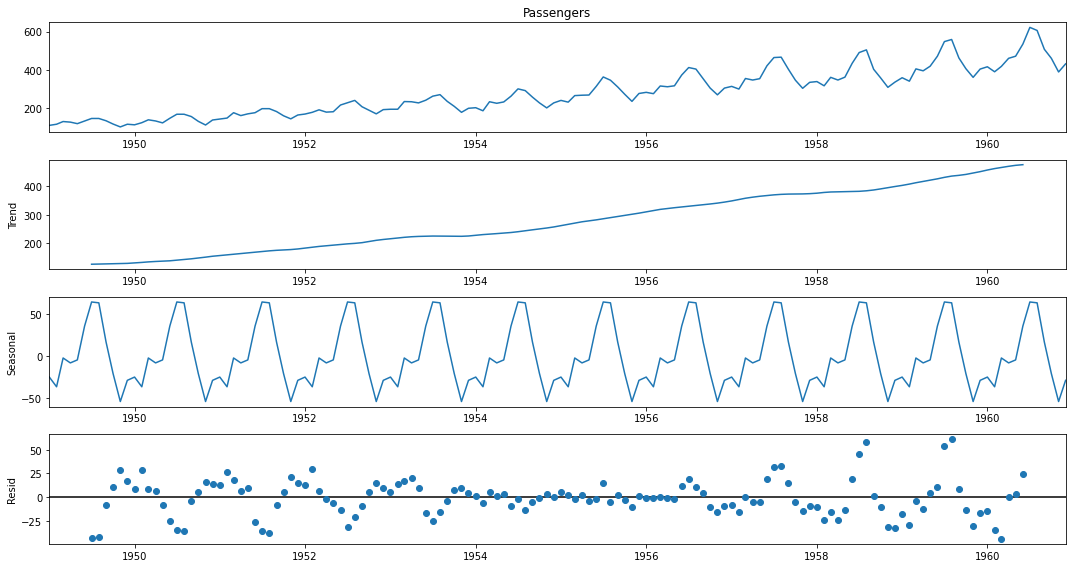

In [20]:
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 15, 8
decompose_series = sm.tsa.seasonal_decompose(df['Passengers'], model='additive')
decompose_series.plot()
plt.show()

> The decomposed time series show an obvious increasing trend and seasonality variations.
Recall that we have initially plotted the moving average on the last 12 months which showed
that it varies with time. This suggests that the data is not stationary. We will now perform
an ADF test to confirm this speculation

In [24]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(df['Passengers'])

print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print(f'No. of lags used: {adf_result[2]}')
print(f'No. of observations used : {adf_result[3]}\n')
print('Critical Values:\n')

for k, v in adf_result[4].items():
    print(f' {k}: {v}')

ADF Statistic: 0.8153688792060502
p-value: 0.991880243437641
No. of lags used: 13
No. of observations used : 130

Critical Values:

 1%: -3.4816817173418295
 5%: -2.8840418343195267
 10%: -2.578770059171598


> From the results obtained, the p-value is greater than the critical value at a 5% significance level and, the ADF statistic is greater that any of the critical values
obtain. #This confirms that the series is indeed non-stationary.

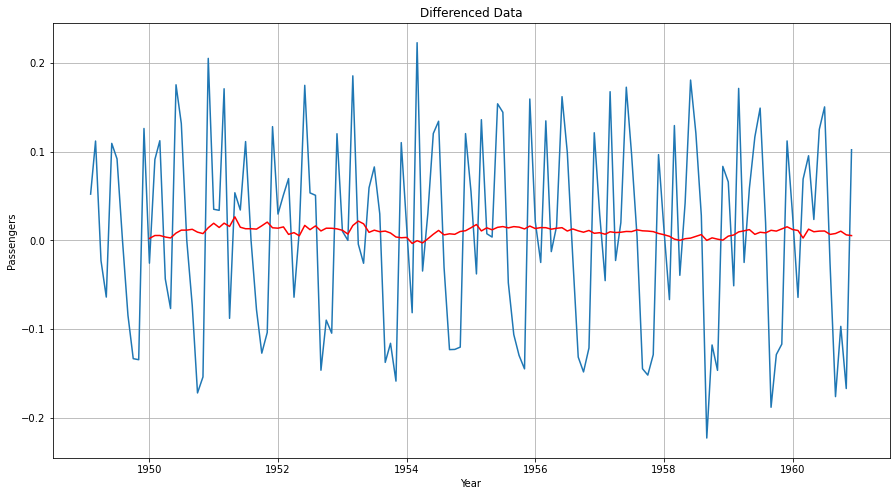

In [27]:
#Convert time series to stationary by removing trend and seasonality
#Transformation and Differencing
df_log = np.log(df)
df_diff = df_log.diff(periods=1)
plt.plot(df_diff.index, df_diff.Passengers, '-')
plt.plot(df_diff.rolling(12).mean(), color='red')
plt.grid()
plt.xlabel('Year')
plt.ylabel('Passengers')
plt.title("Differenced Data");